# Super-Resolution on Inference Images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

Loading the input image from Inference Input folder

In [2]:
img = cv2.imread('Inference_Input/inference_sar1.png', 0)
initial_width, initial_height = img.shape[0], img.shape[1]

## Preprocessing (Cropping to desired patches)

In [3]:
def crop(band_sar, crop_size = 256):

    new_width = int((int(band_sar.shape[0] // crop_size) + 1) * crop_size)
    new_height = int((int(band_sar.shape[1] // crop_size) + 1) * crop_size)
    new_band_sar = -1 * np.ones((new_width, new_height)).astype('float32')
    new_band_sar[:band_sar.shape[0], :band_sar.shape[1]] = band_sar

    num_sampled_0 = int(new_band_sar.shape[0] // crop_size)
    num_sampled_1 = int(new_band_sar.shape[1] // crop_size)
    itera_0 = 0
    itera_1 = 0
    patches_sar = []
    for idx0 in range(num_sampled_0):
        itera_1 = 0
        for idx1 in range(num_sampled_1):
          new_band_sar_1 = new_band_sar[itera_0 : itera_0 + crop_size, itera_1 :itera_1 + crop_size]
          patches_sar.append(new_band_sar_1 / 256)
          itera_1 = itera_1 + crop_size
        itera_0 = itera_0 + crop_size
    return patches_sar, new_width, new_height

### We set resolution scale of 4 and generate input patches

In [4]:
scale_ratio = 4
patch_size = int(256 // scale_ratio)
patches, whole_width, whole_height = crop(img, patch_size)
print(len(patches))

81


## Code for stitching the image back

In [5]:
def stitch_patches(patches, width, height):
    patch_size = patches[0].shape[0]
    num_sampled_0 = int(width // patch_size)
    num_sampled_1 = int(height // patch_size)
    stitched_img = np.zeros((width, height)).astype('float32')
    # stitched_img = -1 * stitched_img

    patch_cnt = 0
    itera_0 = 0
    itera_1 = 0
    for idx0 in range(num_sampled_0):
        itera_1 = 0
        for idx1 in range(num_sampled_1):
          stitched_img[itera_0 : itera_0 + patch_size, itera_1 :itera_1 + patch_size] = patches[patch_cnt]
          itera_1 = itera_1 + patch_size
          patch_cnt += 1
        itera_0 = itera_0 + patch_size
    return stitched_img

## Printing the original SAR Image which to be super-resolved

Current resolution of the SAR image is (512, 512)

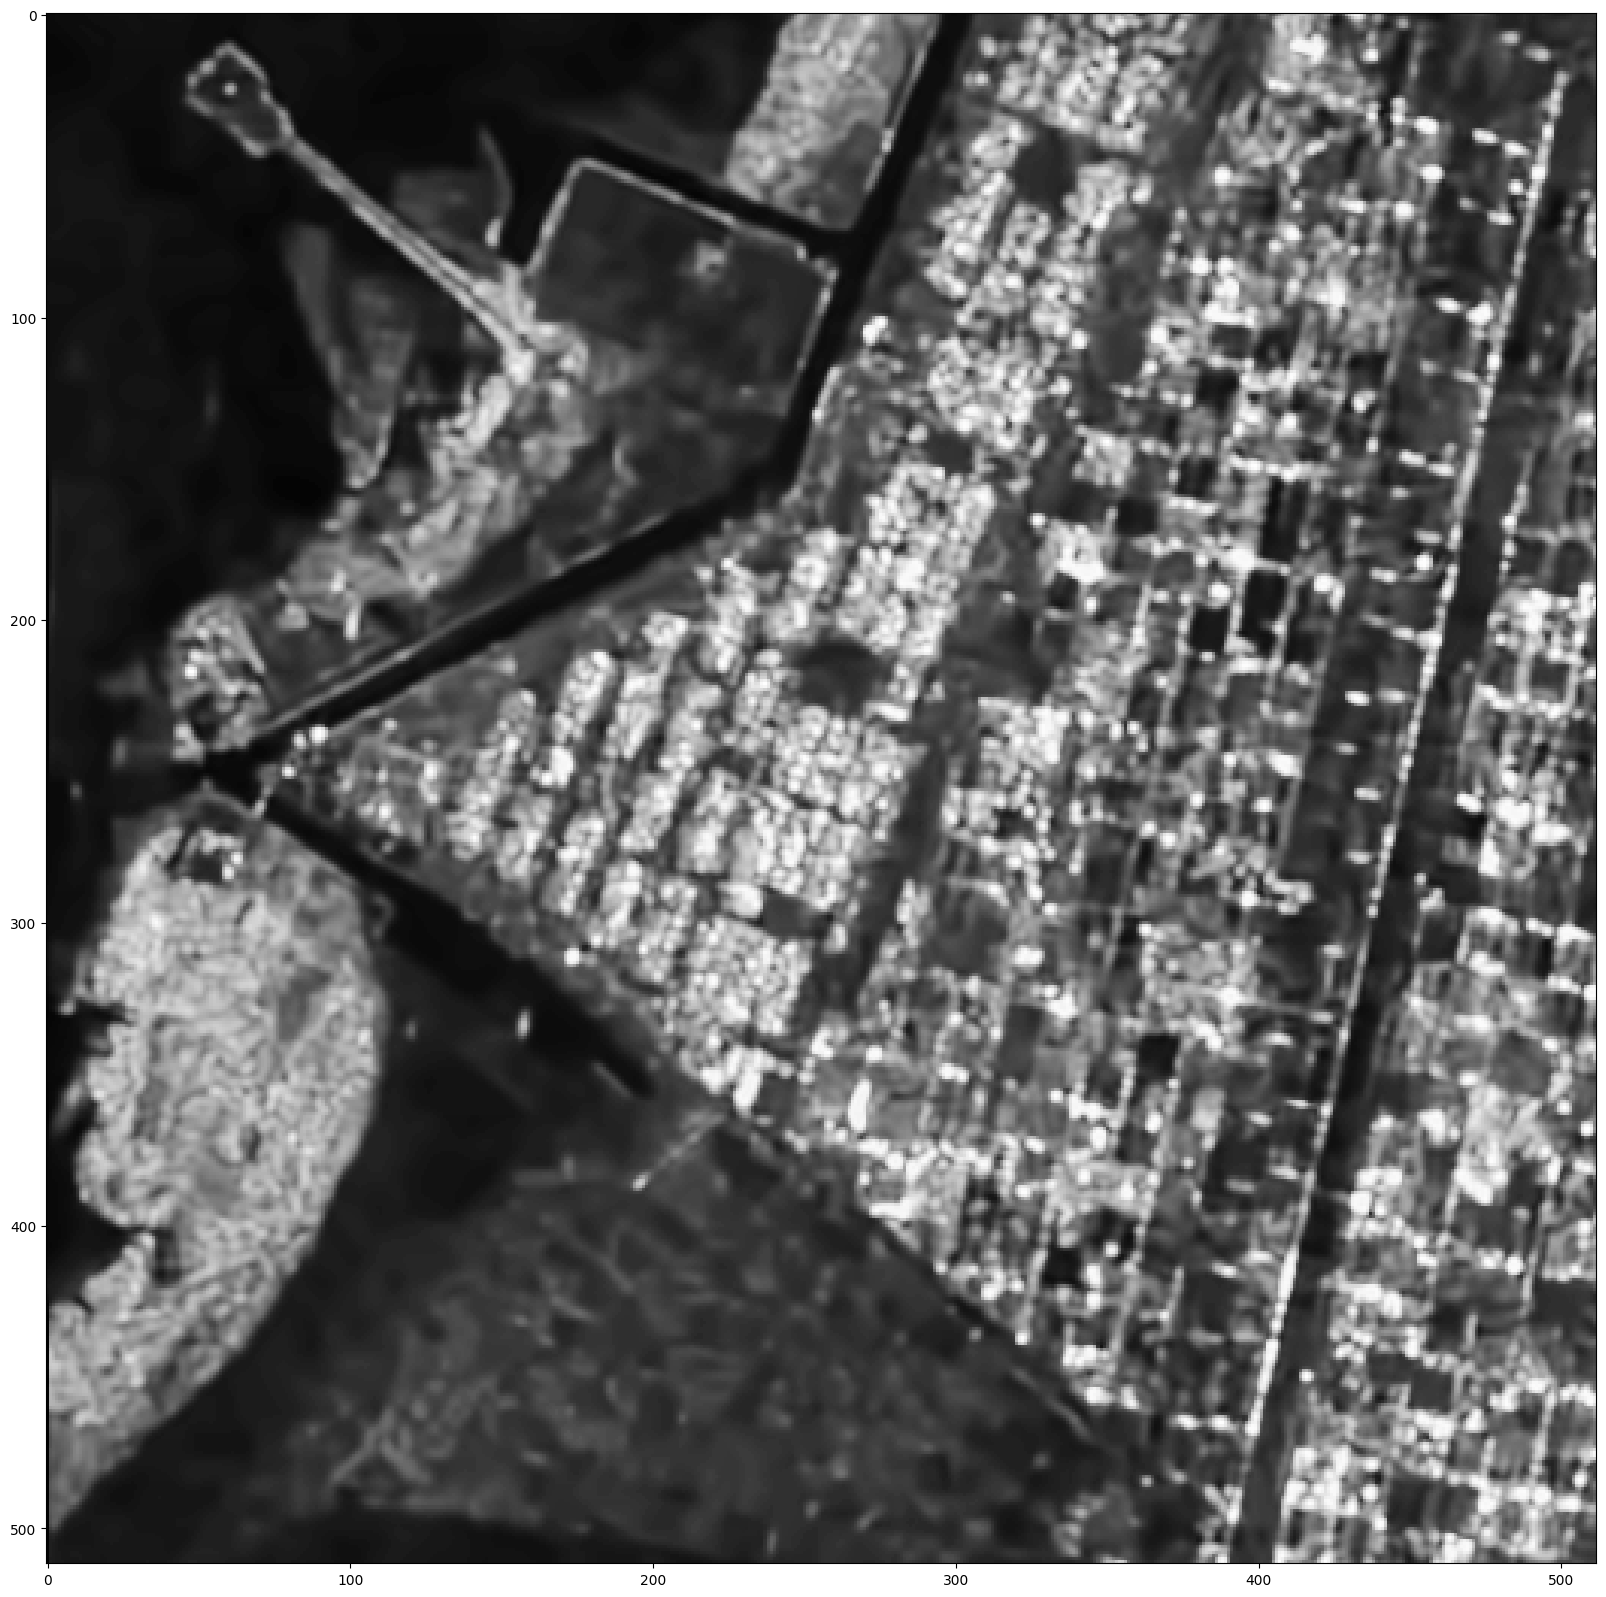

In [6]:
fig, ax = plt.subplots(1, figsize=(20, 40))
plt.imshow(stitch_patches(patches, whole_width, whole_height)[:512,:512], cmap='gray')
plt.show()

# Super-resolving the image patches using pretrained super-resolution model and stitching them back

In [7]:
import torch
from Models.SRUN_SinglePass import SRUN_SinglePass as SRUN
from tqdm import tqdm

srun_model = SRUN(scale_factor=scale_ratio)
srun_model = srun_model.cuda()
path = 'SRUN4_best_ckpt.pth'
best_ckpt = torch.load(path)
srun_model.load_state_dict(best_ckpt['model'])

super_resolved = []
for patch in tqdm(patches):
    tensor_patch = torch.Tensor(patch).unsqueeze(0).unsqueeze(0).cuda()
    out,_ = srun_model(tensor_patch)
    out_img = out.cpu().detach().numpy().squeeze()

    super_resolved.append(out_img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 32.06it/s]


Stitching back the super-resolved patches to form the whole image

Image Resolution after Super-Resolution: 2048x2048


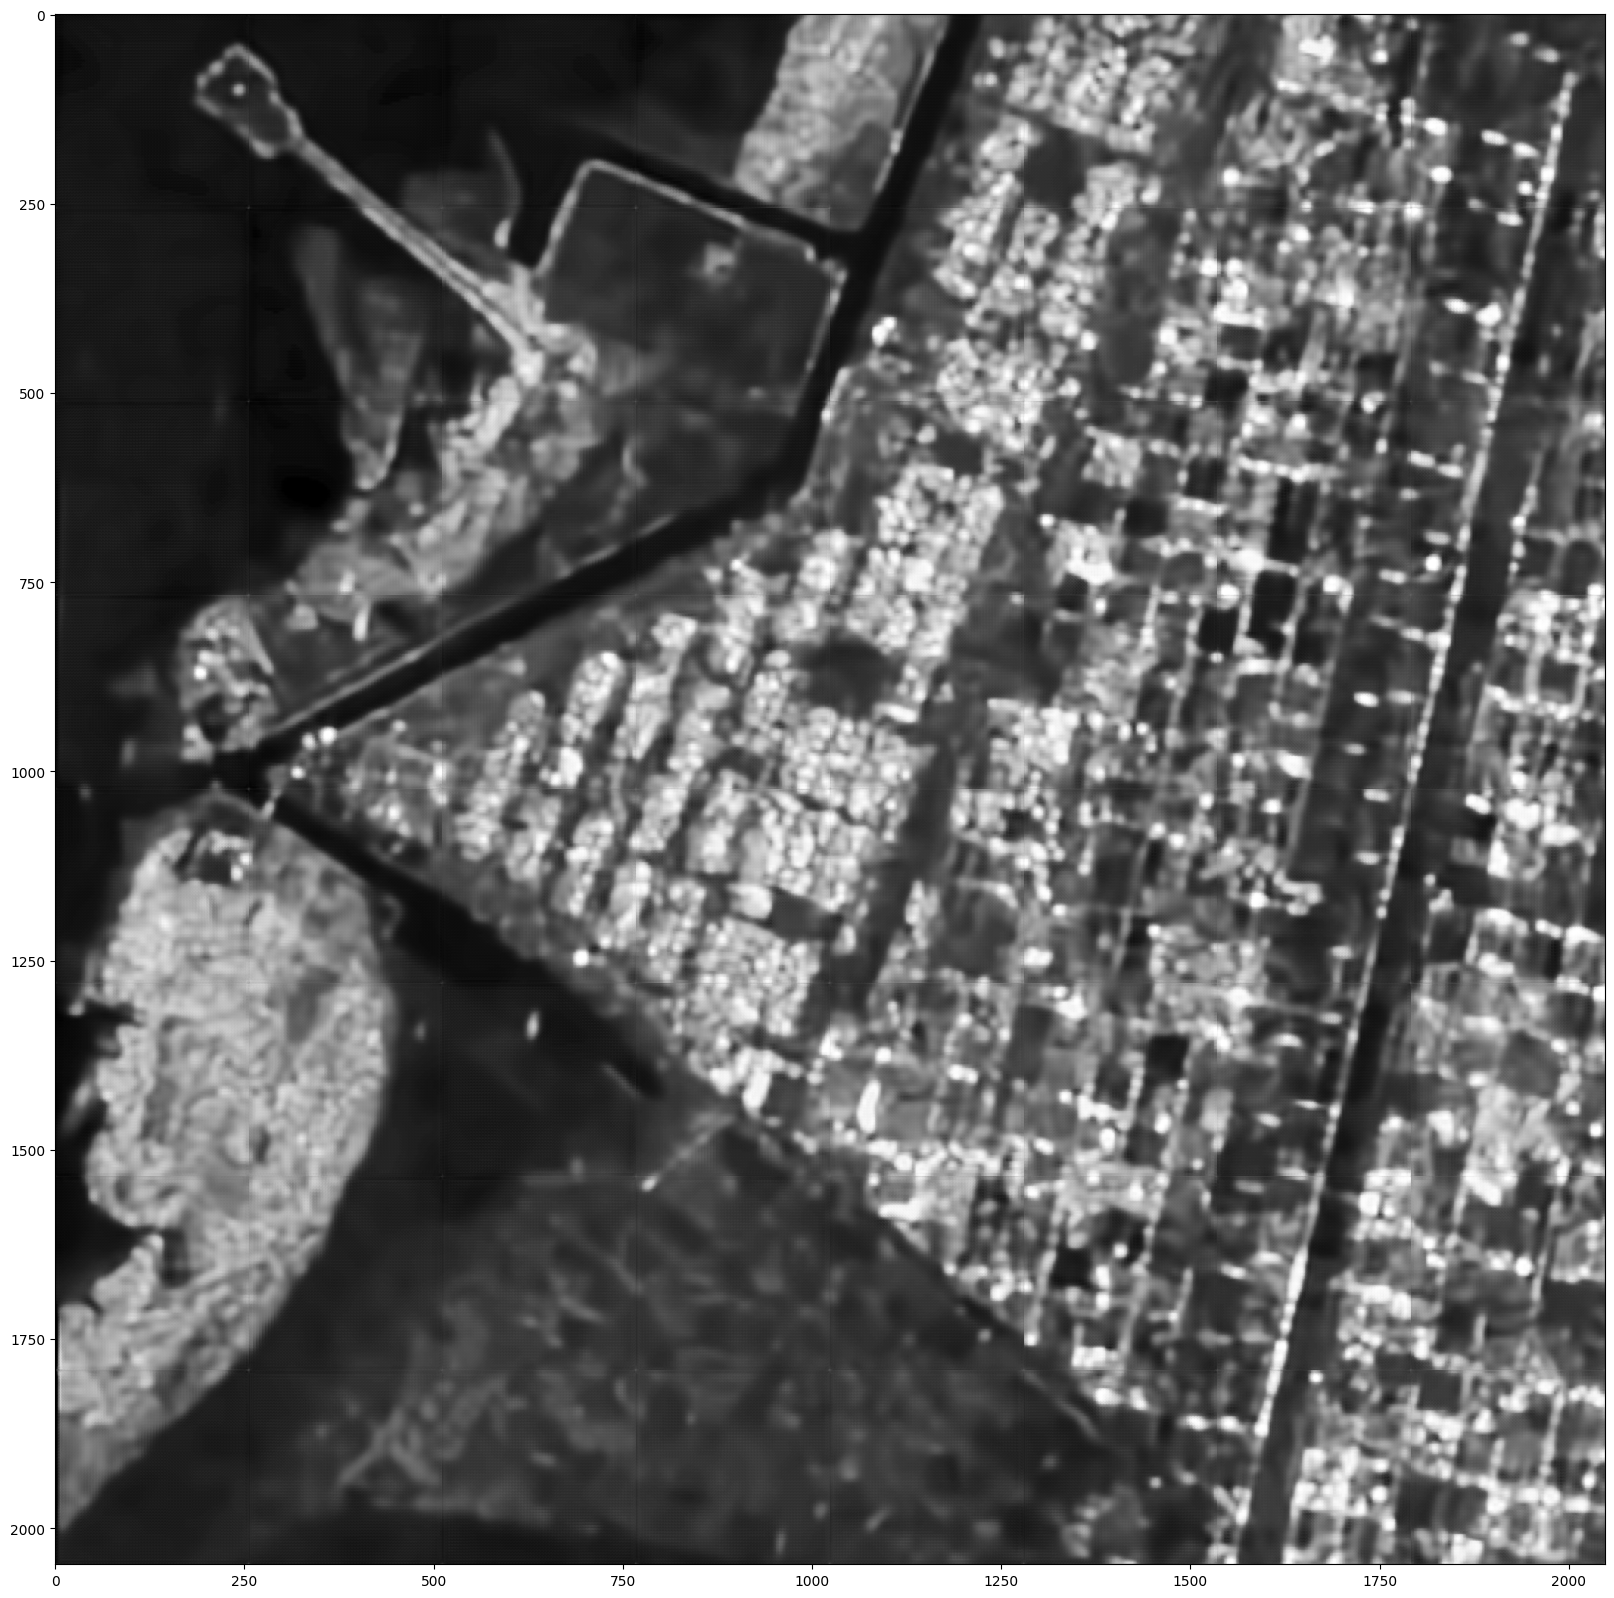

In [8]:
fig, ax = plt.subplots(1, figsize=(20, 40))
super_resolved_stitched = stitch_patches(super_resolved, whole_width*scale_ratio, whole_height*scale_ratio)
super_resolved_stitched = super_resolved_stitched[:initial_width*scale_ratio, :initial_height*scale_ratio]
plt.imshow(super_resolved_stitched, cmap='gray')
print(f'Image Resolution after Super-Resolution: {super_resolved_stitched.shape[0]}x{super_resolved_stitched.shape[1]}')
plt.show()